# A simple example for machine learning with uproot / coffea

Let's try to distinguish DY from tt with rather low level inputs, and then compare to a simple M(ll) based discriminator.

The notebook was tested to run in a conda environment created with:
```
conda create --name coffea_ML uproot coffea matplotlib pandas jupyter -y
```

Then, activate the environment.
```
conda activate coffea_ML
```

The following packages need to be installed with pip:
```
pip install yahist klepto onnxruntime sklearn lbn
```

Install the corresponding jupyter kernel:
```
python -m ipykernel install --user --name=coffea_ML
jupyter nbextension install --py widgetsnbextension --user
jupyter nbextension enable widgetsnbextension --user --py
```

Start jupyter:
```
jupyter notebook --no-browser
```


In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:

# Load some prepared data
sig_file = "/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/nanoSkim_1.root"
bkg_file = "/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/nanoSkim_1.root"

sig = NanoEventsFactory.from_root(bkg_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()
bkg = NanoEventsFactory.from_root(sig_file, schemaclass = NanoAODSchema, entry_stop = int(5e5)).events()

print ("Have %s signal events and %s background events"%(len(sig), len(bkg)))


/home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for

Have 500000 signal events and 500000 background events


In [4]:
from Tools.objects import Collections, choose
from Tools.basic_objects import getJets

We want to apply some very basic event selection, and convert our awkward arrays into a pandas dataframe that's more commonly used in ML.

Because we are interested in a DY (Z->ll) vs ttbar discriminator we select events with exactly two leptons. We can also e.g. extract the leading jet momentum, missing transverse momentum etc.

We also calculate the invariant mass of the leptons, because we want to compare our neural network with a simple cut-and-count discriminator on M(ll).

In [5]:
def convertToDF( df ):

    electrons = Collections(df, 'Electron', 'tightTTH', verbose=0).get()
    muons = Collections(df, 'Muon', 'tightTTH', verbose=0).get()
        
    jets = getJets(df)
    
    eventSelection = ( ((ak.num(electrons, axis=1) + ak.num(muons, axis=1))==2) & (ak.num(jets, axis=1)>0)  )
    
    df = df[eventSelection]
    jets = jets[eventSelection]
    electrons = electrons[eventSelection]
    muons = muons[eventSelection]
    
    leptons = ak.concatenate([electrons, muons], axis=1)

    leading_jet_idx = ak.singletons(ak.argmax(jets.pt, axis=1))
    leading_jet = jets[leading_jet_idx]
    
    leading_lepton_idx = ak.singletons(ak.argmax(leptons.pt, axis=1))
    trailing_lepton_idx = ak.singletons(ak.argmin(leptons.pt, axis=1))
    
    leading_lepton = leptons[leading_lepton_idx]
    
    trailing_lepton = leptons[trailing_lepton_idx] # this works because we select events with just two leptons in the end
    
    dileptons = choose(leptons,2)
    
    return pd.DataFrame({
            'leadingJet_pt': ak.flatten(leading_jet.pt, axis=1), 
            'lep0_pt': ak.flatten(leading_lepton.pt, axis=1),
            'lep0_eta': ak.flatten(leading_lepton.eta, axis=1),
            'lep0_phi': ak.flatten(leading_lepton.phi, axis=1),
            'lep0_mass': ak.flatten(leading_lepton.mass, axis=1),
            'lep1_pt': ak.flatten(trailing_lepton.pt, axis=1),
            'lep1_eta': ak.flatten(trailing_lepton.eta, axis=1),
            'lep1_phi': ak.flatten(trailing_lepton.phi, axis=1),
            'lep1_mass': ak.flatten(trailing_lepton.mass, axis=1),
            'mll': ak.flatten(dileptons.mass, axis=1), 
            'dilepton_pt': ak.flatten(dileptons.pt, axis=1),
            'MET_pt': df.MET.pt,
    })




In [6]:
sig_df = convertToDF( sig )
bkg_df = convertToDF( bkg )

In [7]:
# usually we have less signal than background, but we balance our data sets in both directions
nSignal = len(sig_df)
nBkg = len(bkg_df)

print ("Total number of signal: %s, background: %s"%(nSignal, nBkg))

# Balance the signal and background sets
if nBkg>nSignal:
    tmp_bkg_df = bkg_df.sample( n = nSignal )
    tmp_sig_df = sig_df
else:
    tmp_bkg_df = bkg_df
    tmp_sig_df = sig_df.sample( n = nBkg )
    
y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

Total number of signal: 257266, background: 134298


In [8]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

In [10]:
len(y_train)

134298

Here we define the variables we want to use for the neural network training. The more information we add, the better the discriminator (or NN response) will be. If we e.g. only use the lepton mass and pt, the neural network will not be able to learn enough to reproduce the performance of the invariant mass of the two leptons.

In [15]:
#variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep1_pt', 'lep1_eta', 'lep1_phi']
variables = ['lep0_mass', 'lep0_pt', 'lep1_mass', 'lep1_pt']


X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [16]:
len(X_train.values)

134298

In [53]:
NHLayer = 5
epochs = 500
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

## Editor's note: don't go too crazy with nodes and layers if the data set is small or nothing will be learned at all.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 17,721
Trainable params: 17,721
Non-trainable params: 0
__________________________________________________

In [54]:
# Fit the model to our training data. This can take a few minutes to run.

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
model.save( 'training.h5a' )

INFO:tensorflow:Assets written to: training.h5a/assets


We can then look at the loss and accuracy in training and validation. A sign of overfitting would be if we the performance is very different in training and validation.

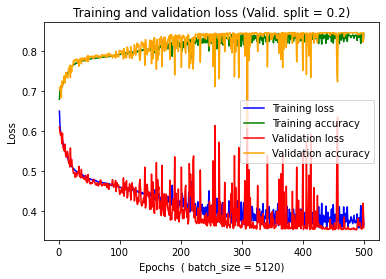

In [55]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'blue', label='Training loss')
plt.plot(epochslist, acc_values,'green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [56]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

# as a comparison, use a mll based discriminator:
y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

Text(0, 0.5, 'Events')

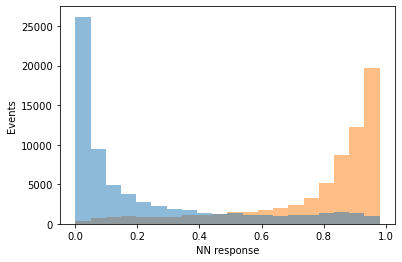

In [59]:
# Look at a plot of the discriminator.
# Ideally, the two populations (signal and background) are completely seperated.
# In reality, there will be some remaining overlap.

xbin = 20
hist, bins, ax = plt.hist( [
    y_test_pred[y_test==0].values.flatten(),
    y_test_pred[y_test==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

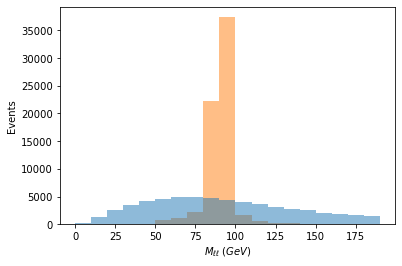

In [60]:
# Compare that distribution with M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [
    X_myTest[['mll']][y_test==0].values.flatten(),
    X_myTest[['mll']][y_test==1].values.flatten(),
], xbin, log=False, histtype='stepfilled', alpha=0.5) 
plt.xlabel(r'$M_{\ell\ell}\ (GeV)$')
plt.ylabel('Events')

In [61]:
# check of sample sizes
print(y_test_pred[y_test==0].size)
print(y_test_pred[y_test==1].size)

67358
66940


The ROC curve, and especially the area under the curve (AUC) give us an idea of the performance of our NN, and a comparison to the M(ll) approach.

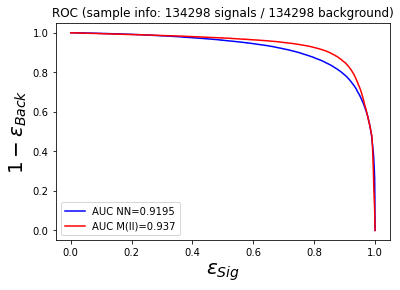

In [62]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, color='blue', label= 'AUC NN=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, label= 'AUC M(ll)=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'True positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-False positive rate' 
plt.legend(loc ='lower left')


Some observations:
- very similar performance between M(ll) and NN if we use all the lepton kinematics as input to the NN
- overtraining seems to be not a big problem, and one can use a large number of epochs
- we still use a "small" data set
- maybe a different model is better suited for our problem?

To improve the performance of the NN, we can use more inputs to the NN and rerun the training.

# Using some physics knowledge (4 vectors)

We can try to use a network that knows about 4 vectors and see if this further improves the performance

In [3]:
from lbn import LBN, LBNLayer

In [4]:
def convertTo4Vec( df ):
       
    lead_lep = np.array(list(zip(
        df['lead_lep_energy'],
        df['lead_lep_px'],
        df['lead_lep_py'],
        df['lead_lep_pz'],
    )))
    
    sublead_lep = np.array(list(zip(
        df['sublead_lep_energy'],
        df['sublead_lep_px'],
        df['sublead_lep_py'],
        df['sublead_lep_pz'],
    )))

    jet1 = np.array(list(zip(
        df['j1_energy'],
        df['j1_px'],
        df['j1_py'],
        df['j1_pz'],
    )))
    
    jet2 = np.array(list(zip(
        df['j2_energy'],
        df['j2_px'],
        df['j2_py'],
        df['j2_pz'],
    )))
    
    jet3 = np.array(list(zip(
        df['j3_energy'],
        df['j3_px'],
        df['j3_py'],
        df['j3_pz'],
    )))
    
    jet4 = np.array(list(zip(
        df['j4_energy'],
        df['j4_px'],
        df['j4_py'],
        df['j4_pz'],
    )))
    
    jet5 = np.array(list(zip(
        df['j5_energy'],
        df['j5_px'],
        df['j5_py'],
        df['j5_pz'],
    )))

    particles = np.array(list(zip(lead_lep, sublead_lep, jet1, jet2, jet3, jet4, jet5)))
    return particles

In [5]:
def prepare_data(f_in, selection, robust=False, reuse=False, fout=None, label_ID='label'):

    if not reuse:
        
        df = pd.read_hdf(f_in) # load data processed with ML_processor.py
        df = df[selection]


        labels = df[label_ID].values
        process_labels = df['label'].values
        
        df = df[(process_labels<5)]
        labels = labels[process_labels<5] # filter out high weight DY events

        df = df[(labels<5)]
        labels = labels[labels<5] # filter out high weight DY events
        
        df_signal = df[(df[label_ID]==0)]
        df_bkg    = df[(df[label_ID]==1)]
        df_in = pd.concat([df_signal, df_bkg])
        labels = df_in[label_ID].values
        

        df_train, df_test, y_train, y_test = train_test_split(df_in, labels, train_size= int( 0.9*labels.shape[0] ), random_state=42 )

        df_train['test_label'] = np.zeros(len(df_train))
        df_test['test_label'] = np.ones(len(df_test))

        df = pd.concat([df_train, df_test])

        if fout:
            df.to_hdf(fout, key='df', format='table', mode='w')

    else:
        df = pd.read_hdf(f_in)

        df_train = df[df['test_label']==0]
        df_test = df[df['test_label']==1]

        y_train = df_train[label_ID].values
        y_test = df_test[label_ID].values

    for i in range(5):
        print ("Number of events in category %s:"%i, len(df[df[label_ID]==i]))

    return df_train, df_test, y_train, y_test#, df_mean, df_std


In [ ]:
df = pd.read_hdf('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5')
preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))
df_train, df_test, y_train_int, y_test_int = prepare_data('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5', preselection, reuse=False, fout='data/multiclass_input_v4_split_%s.h5', label_ID='label')

                  
X_train = convertTo4Vec(df_train)
X_test  = convertTo4Vec(df_test)


In [17]:
epochs = 50  # 50 -> 200
batch_size = 5120
validation_split = 0.2

In [19]:
np.where(y_train==2)

(array([], dtype=int64),)

In [ ]:
for x in range(len(y_train)):
    if y_train[x] != 0:
        y_train[x] = 2
        
for x in range(len(y_train)):
    if y_train[x] == 0:
        y_train[x] = 1

for x in range(len(y_train)):
    if y_train[x] != 1:
        y_train[x] = 0
        
for x in range(len(y_test)):
    if y_test[x] != 0:
        y_test[x] = 2

for x in range(len(y_test)):
    if y_test[x] == 0:
        y_test[x] = 1

for x in range(len(y_test)):
    if y_test[x] != 1:
        y_test[x] = 0

In [8]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((7, 4), n_particles=7, boost_mode=LBN.PAIRS, features=["E", "px", "py", "pz"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(X_train)

In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=validation_split, verbose=0)

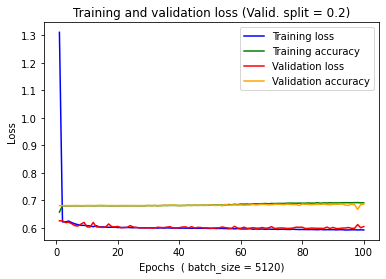

In [10]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, color='blue', label='Training loss')
plt.plot(epochslist, acc_values, color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [11]:
y_test_pred = pd.DataFrame(model.predict( X_test  ) )
y_train_pred = pd.DataFrame(model.predict( X_train  ) )

In [24]:
len(y_test_pred)

12957

In [12]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
fpr_train, tpr_train, thresholds_train = roc_curve( y_train, y_train_pred )

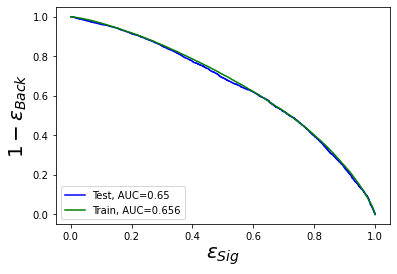

In [13]:
auc_val_test = auc(fpr_test, tpr_test)
auc_val_train = auc(fpr_train, tpr_train)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Test, AUC=' + str(round(auc_val_test,4)))
plt.plot( tpr_train, 1-fpr_train, 'g', label= 'Train, AUC=' + str(round(auc_val_train,4)))

plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'True positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-False positive rate' 
plt.legend(loc ='lower left')

For some reason we see quite some difference between the training and validation set in terms of loss an accuracy, hinting at overfitting. However, if we look at the ROC curves and their AUC, we see very similar performance on two independet sets, the training and test set.

We see a slightly better performance than with the default NN we used above.

Text(0, 0.5, 'Events')

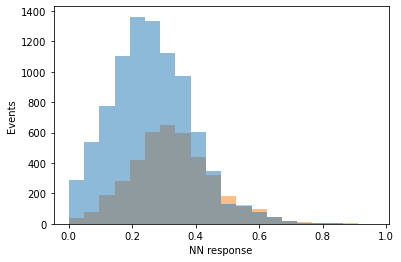

In [14]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_test_pred[y_test==0].values.flatten(),
    y_test_pred[y_test==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

Text(0, 0.5, 'Events')

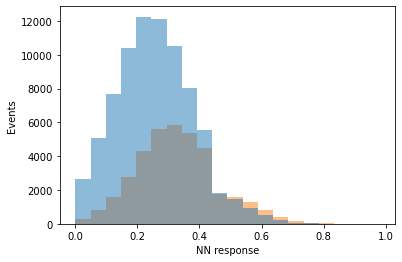

In [15]:
xbin = 20
hist, bins, ax = plt.hist( [
    y_train_pred[y_train==0].values.flatten(),
    y_train_pred[y_train==1].values.flatten(),
], xbin, log=False, label=['Background ('+ str((y_train==0).sum()) +')' ,'Signal ('+ str((y_train==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.xlabel('NN response')
plt.ylabel('Events')

In [6]:
df = pd.read_hdf('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5')
preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2) & (df['n_fwd']>0))
df_train, df_test, y_train_int, y_test_int = prepare_data('/hadoop/cms/store/user/dspitzba/ML/multiclass_input_v4.h5', preselection, reuse=False, fout='data/multiclass_input_v4_split_%s.h5', label_ID='label')

<ipython-input-5-23a30458717f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['test_label'] = np.zeros(len(df_train))
<ipython-input-5-23a30458717f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['test_label'] = np.ones(len(df_test))


Number of events in category 0: 88155
Number of events in category 1: 41409
Number of events in category 2: 0
Number of events in category 3: 0
Number of events in category 4: 0


In [10]:
X_train=df_train
X_test=df_test

y_train = y_train_int
y_test = y_test_int

In [8]:
epochs = 50  # 50 -> 200
batch_size = 5120
validation_split = 0.2

In [16]:
y_train

array([1., 0., 0., ..., 0., 0., 1.])

In [11]:
NHLayer = 5
epochs = 500
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 864       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 18,545
Trainable params: 18,545
Non-trainable params: 0
__________________________________________________

In [12]:
#variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep1_pt', 'lep1_eta', 'lep1_phi']
#variables = ['lead_lep_pt','sublead_lep_pt', ]
variables = [
        ## best results with all variables, but should get pruned at some point...
        'n_jet',
        ##'n_central',
        ###'n_fwd',
        'n_tau',
        'n_track',
        'st',
        ##'ht',
        'met',
        'mjj_max',
        'delta_eta_jj',
        'lead_lep_pt',
        'lead_lep_eta',
        'sublead_lep_pt',
        'sublead_lep_eta',
        'dilepton_mass',
        'dilepton_pt',
        'fwd_jet_pt',
        'fwd_jet_p',
        'fwd_jet_eta',
        'lead_jet_pt',
        'sublead_jet_pt',
        'lead_jet_eta',
        'sublead_jet_eta',
        'lead_btag_pt',
        'sublead_btag_pt',
        'lead_btag_eta',
        'sublead_btag_eta',
        'min_bl_dR',
        'min_mt_lep_met',
    ]


X_train = df_train[variables]
X_test = df_test[variables]
#X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [13]:
history = model.fit(X_train.values, y_train, epochs=100, batch_size=batch_size, validation_split=validation_split, verbose=0)

ValueError: in user code:

    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/users/zmei/miniconda3/envs/coffea_ML/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:251 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 107 but received input with shape (None, 26)


In [27]:
df_train.keys()

Index(['mjj_max', 'delta_eta_jj', 'met', 'ht', 'st', 'n_jet', 'n_btag',
       'n_fwd', 'n_central', 'n_tau',
       ...
       'j4_py', 'j4_pz', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_energy', 'j5_px',
       'j5_py', 'j5_pz', 'test_label'],
      dtype='object', length=107)